In [2]:
import numpy as np
import pandas as pd
import cpmpy as cp
from cctbx.sgtbx.direct_space_asu.reference_table import get_asu
from pyxtal import Group, Wyckoff_position

In [3]:
sg = Group(99)
asu = get_asu(sg.number)
asu.show_comprehensive_summary()

Hall symbol: P 4 -2
Number of cuts: 5
    & x0
    & y2
    & z0
    & +z1
    & -p0


In [4]:
N = []
c = []
for cut in asu.cuts:
    lcm = cut.lcm_of_denominators()
    N.append([int(x * lcm) for x in cut.n])
    c.append(int(cut.c * lcm))

N = np.array(N)
c = np.array(c)

N, c

(array([[ 1,  0,  0],
        [ 0, -2,  0],
        [ 0,  0,  1],
        [ 0,  0, -1],
        [-1,  1,  0]]),
 array([0, 1, 0, 1, 0]))

In [5]:
import plotly.express as px
from baysic.feature_space import FeatureSpace

fs = FeatureSpace(sg.number)

xyz_u = np.mgrid[0:1:12j, 0:1:12j, 0:1:12j].reshape(3, -1).T

xyz = fs.to_general_positions(xyz_u)
xx, yy, zz = xyz.T

fig = px.scatter_3d(x=xx, y=yy, z=zz)
fig.update_traces(marker=dict(size=2))

In [6]:
import torch

x = torch.randn(1000, 1)
y = torch.randn(1000, 1)

torch.matmul(torch.randn(2, 7, 1, 1, 4), torch.randn(10, 4, 4)).shape

torch.Size([2, 7, 10, 1, 4])

In [7]:
import itertools
from scipy.spatial.distance import pdist
wp = sg.Wyckoff_positions[0]

pos = []
for op in wp.ops:
    pts = op.operate_multi(xyz)
    pos.append(pts)
    

pos = np.stack(pos, axis=1)

dists = []
for i in range(pos.shape[0]):
    vecs = pos[i][np.newaxis,:,:]-pos[i][:,np.newaxis,:]
    # just the upper triangle
    triu = np.triu_indices_from(vecs[:, :, 0], 1)
    vecs = vecs[triu[0], triu[1], :]
    # distances mod 1: get closest pair modulo lattice
    dists.append(np.sqrt(np.square(vecs % 1).sum(axis=1)))


dists = np.stack(dists)
pos.shape, dists.shape

((1728, 8, 3), (1728, 28))

In [8]:
dir(asu)

['__and__',
 '__class__',
 '__copy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_box_corner',
 'add_buffer',
 'add_plane',
 'add_planes',
 'box_max',
 'box_min',
 'change_basis',
 'cuts',
 'define_metric',
 'extract_all_cuts',
 'hall_symbol',
 'in_which_cuts',
 'is_inside',
 'shape_only',
 'shape_vertices',
 'show_comprehensive_summary',
 'show_summary']

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



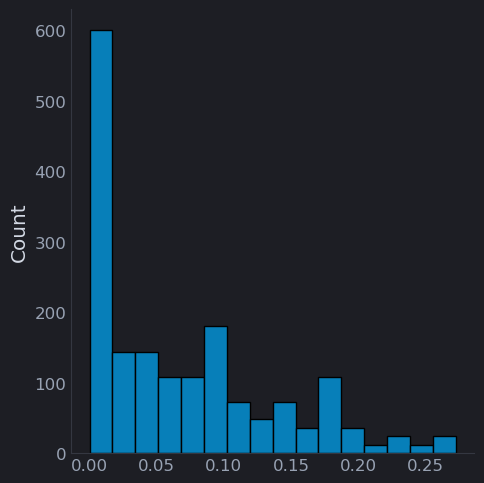

In [9]:
import seaborn as sns
import rho_plus as rp

theme, cs = rp.mpl_setup(True)
rp.plotly_setup(True)

sns.displot(dists.min(axis=1))

In [10]:
from pymatgen.analysis.molecule_structure_comparator import CovalentRadius
from plotly import graph_objects as go

xx_u, yy_u, zz_u = xyz_u.T
xx, yy, zz = xyz.T
lat_scale = 20
rad = 2 * CovalentRadius.radius['Sn']
ratio = dists.min(axis=1) * lat_scale / rad
# mask = ratio > 0.75
# fig = px.scatter_3d(x=xx[mask], y=yy[mask], z=zz[mask], color=ratio[mask], color_continuous_scale='sunset_r')
# fig.update_traces(marker=dict(size=3))
mask = zz_u == zz_u[0]
fig = go.Figure(go.Mesh3d(x=xx[mask], y=yy[mask], z=ratio[mask]))
fig

In [11]:
pts = wp.apply_ops([0.9086, 0.2501, 0.3288]).round(2)
pts -= np.floor(pts)
pts = np.where(pts > 0.5, pts - 1, pts)
pts
[p for p in pts if asu.is_inside(p)]

[array([0.09, 0.25, 0.33])]

In [12]:
pts.shape

(8, 3)

In [13]:
offset.shape

NameError: name 'offset' is not defined

In [ ]:
from pymatgen.core import Structure

df = pd.read_pickle('merwp.opsged_test_data3.pkl')

structs: list[Structure] = df.struct

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



(0.0, 3.897635677845276)

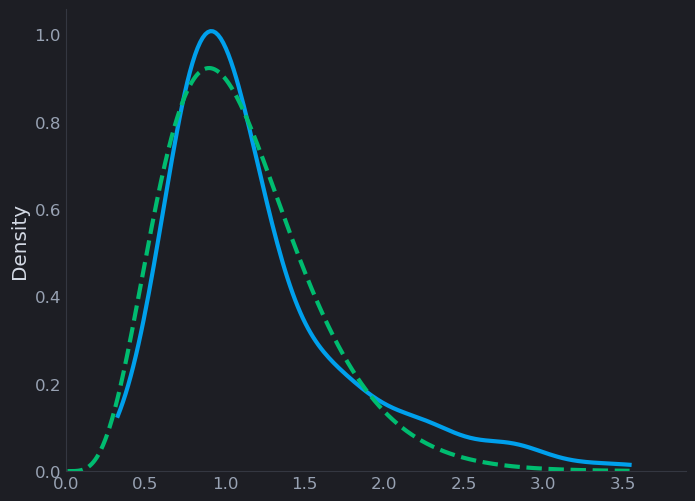

In [ ]:
import matplotlib.pyplot as plt
import pyro.distributions as dist
import torch
from pymatgen.analysis.molecule_structure_comparator import CovalentRadius
vals = []
for struct in structs:
    radii = np.array([CovalentRadius.radius[el.symbol] for el in struct.composition.elements])
    count = list(struct.composition.values())
    atomic_volume = np.dot(count, 4 * np.pi / 3 * radii ** 3)
    vals.append(struct.lattice.volume / atomic_volume)

vals = np.array(vals)
vals -= np.median(vals)
vals += 1
xx = np.linspace(0.01, max(vals), 1000)

v = 5
a = (1 + 0.5/v) * v
probs = torch.exp(dist.Gamma(a, v).log_prob(torch.tensor(xx)))
yy = probs.numpy()


sns.kdeplot(vals, cut=0)
plt.plot(xx, yy, color=cs[1], ls='--')
plt.xlim(0, max(vals) * 1.1)

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: ylabel='Count'>

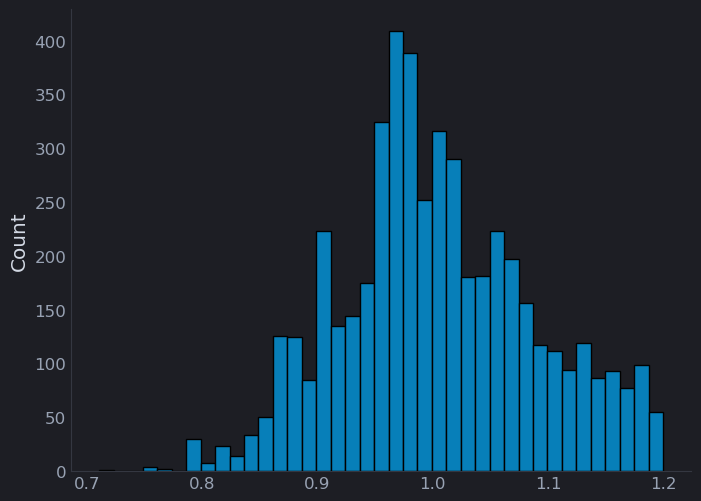

In [ ]:
import matplotlib.pyplot as plt
import pyro.distributions as dist
import torch
from pymatgen.analysis.molecule_structure_comparator import CovalentRadius
vals = []
for struct in structs:
    radii = np.array([CovalentRadius.radius[site.specie.symbol] for site in struct.sites])
    cov_length = radii[np.newaxis, :] + radii[:, np.newaxis]
    atom_dist = struct.distance_matrix / cov_length
    atom_pdist = atom_dist[np.triu_indices_from(atom_dist, 1)]
    vals.append(atom_pdist)

vals = np.hstack(vals)

sns.histplot(vals[vals < 1.2])

In [ ]:
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

df = pd.read_pickle('merged_test_data3.pkl')

sga = SpacegroupAnalyzer(df.iloc[0]['struct'])
symm = sga.get_conventional_standard_structure()
sga.get_symmetrized_structure().wyckoff_symbols

['4e', '4e', '4e', '4e', '4e']

In [ ]:
symm.lattice

Lattice
    abc : 6.39345179642068 6.80623043 8.181316902308122
 angles : 90.0 127.02483022044211 90.0
 volume : 284.2313547867366
      A : 0.0 6.39345179642068 0.0
      B : 6.80623043 0.0 0.0
      C : 0.0 -4.926470544655706 -6.531755830451126
    pbc : True True True

In [ ]:
df.query('CrystalSystem == "Cubic"')

,material_id,formula_pretty,nsites,spacegroup,nelements,elements_list,CrystalSystem,category,nontrivial_coordinates,struct
12,mp-1111927,K2LiCrF6,10,225,4,Cr F K Li,Cubic,template-based_quartenary,0,"[[2.029107 2.029107 2.029107] K, [6.087321 6.0..."
15,mp-1106325,CaCu3Pt4O2,20,204,4,Ca Cu O Pt,Cubic,template-based_quartenary,1,"[[0. 0. 0.] Ca, [0. 0. 3.808434] C..."
16,mp-1106150,CeMn4Cu3O2,20,204,4,Ce Cu Mn O,Cubic,template-based_quartenary,1,"[[0. 0. 0.] Ce, [ 1.858076 -1.858076 -1.858076..."
17,mp-1106068,LaCr4Cu3O2,20,204,4,Cr Cu La O,Cubic,template-based_quartenary,1,"[[0. 0. 0.] La, [ 1.8600665 -1.8637325 -1.8631..."
18,mp-1106004,HoFe4Cu3O2,20,204,4,Cu Fe Ho O,Cubic,template-based_quartenary,1,"[[0. 0. 0.] Ho, [ 1.8650475 1.8650475 -1.8650..."
...,...,...,...,...,...,...,...,...,...,...
173,mp-1106196,Lu4Ga2Ni,17,229,3,Ga Lu Ni,Cubic,template-based_ternary,1,"[[ 2.09827148 2.09827148 -2.09827148] Lu, [ 2..."
175,mp-1106064,Ho4Ga2Ni,17,229,3,Ga Ho Ni,Cubic,template-based_ternary,1,"[[ 2.11805495 2.11805495 -2.11805495] Ho, [ 2..."
176,mp-1105955,Er3Cu3Sb4,20,220,3,Cu Er Sb,Cubic,template-based_ternary,5,"[[-2.3728156 3.55922339 4.74563119] Er, [2...."
177,mp-1105893,La3Cu3Bi4,20,220,3,Bi Cu La,Cubic,template-based_ternary,5,"[[-2.52068287 3.7810243 5.04136574] La, [2...."


In [30]:
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

df = pd.read_pickle('merged_test_data3.pkl')

sgas = []
symms = []
wycks = []
for i, row in df.iterrows():
    sga = SpacegroupAnalyzer(row['struct'])
    sgas.append(sga)
    symm = sga.get_symmetrized_structure()
    symms.append(symm)
    wycks.extend(list(set(symm.wyckoff_symbols)))

In [31]:
wydf = pd.DataFrame([[w[0] for w in wycks], [w[1] for w in wycks]]).T
wydf.columns = ['index', 'letter']
wydf['index'] = wydf['index'].astype(int)
wydf

,index,letter
0,4,e
1,1,a
2,3,g
3,2,d
4,3,f
...,...,...
542,2,j
543,2,g
544,6,a
545,8,c


In [36]:
sga.get_space_group_number()

220

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: ylabel='Count'>

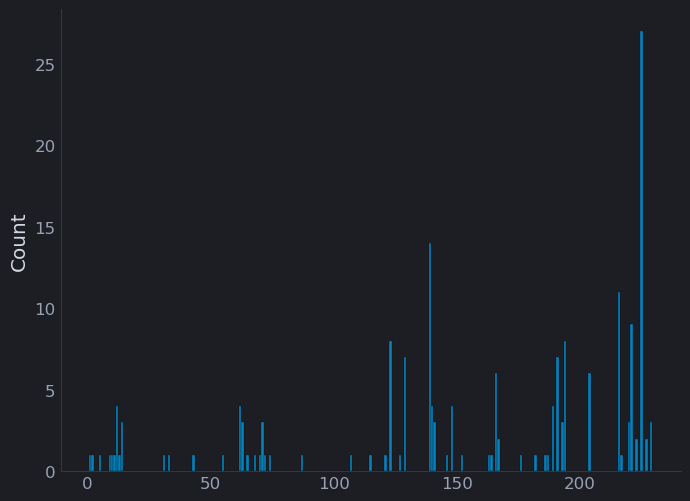

In [37]:
sns.histplot([sga.get_space_group_number() for sga in sgas], discrete=True)

In [39]:
torch.linspace(0, 1, 5) * (5 - 1)

tensor([0., 1., 2., 3., 4.])

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/home/nicholas/anaconda3/envs/baysic/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='index', ylabel='Count'>

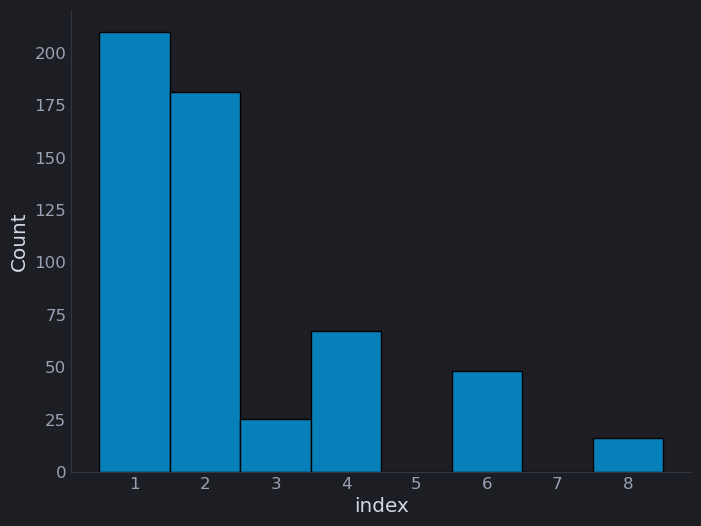

In [32]:
sns.histplot(wydf, x='index', discrete=True)